In [56]:
# import libs
import numpy as np
import pandas as pd
import seaborn as sns
from Titanic.CheckAccuracy import CheckAccuracy
from Titanic.common.multi_layer_net_extend import MultiLayerNetExtend
from matplotlib import pyplot as plt

sns.set(style='darkgrid')

In [57]:
# Functions
def calc_nan_rate(df, v):
    total = df[v].isnull().sum()
    percent = round(total/len(df[v])*100, 2)
    return pd.DataFrame([[total, percent]], columns=["total", "percent"], index=[v])


In [58]:
# read data
low_train_data = pd.read_csv('../Titanic/titanic_data/train.csv')
low_test_data = pd.read_csv('../Titanic/titanic_data/test.csv')

In [59]:
low_train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [60]:
# To check NaN
print(low_train_data.isna().any())

# To count how many NaN does Age/Cabin/Embarked have
print(calc_nan_rate(low_train_data, "Age")) # To fill or To drop?
print(calc_nan_rate(low_train_data, "Cabin")) # -> To drop
print(calc_nan_rate(low_train_data, "Embarked")) # -> To fill by most amount data

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool
     total  percent
Age    177    19.87
       total  percent
Cabin    687     77.1
          total  percent
Embarked      2     0.22


-0.07722109457217737


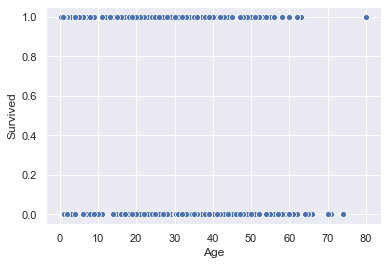

In [61]:
# To analyse "Age" data to decide to fill or to drop
low_train_data['Age'].describe()
# g = sns.FacetGrid(low_train_data, hue='Sex', height=5)
# g.map(sns.distplot, "Age", kde=False)
# g.add_legend()
sns.scatterplot(data=low_train_data, x='Age', y='Survived')
print(low_train_data.corr()['Age']['Survived']) # -> -0.077, must be dropped?



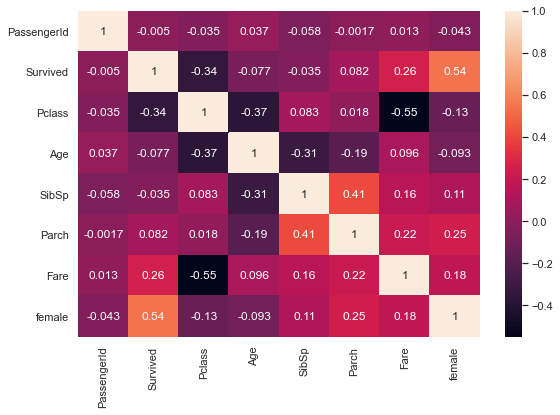

In [62]:
titanic_heatmap = low_train_data.copy()

# check heat map
plt.figure(figsize=(9, 6))

# translate category data to amount data
titanic_heatmap['female'] = titanic_heatmap.Sex.apply(lambda x: True if x == 'female' else False)

sns.heatmap(titanic_heatmap.corr(), annot=True)

# Survived relate to Pclass/Fare/Sex
# Should I use these data?

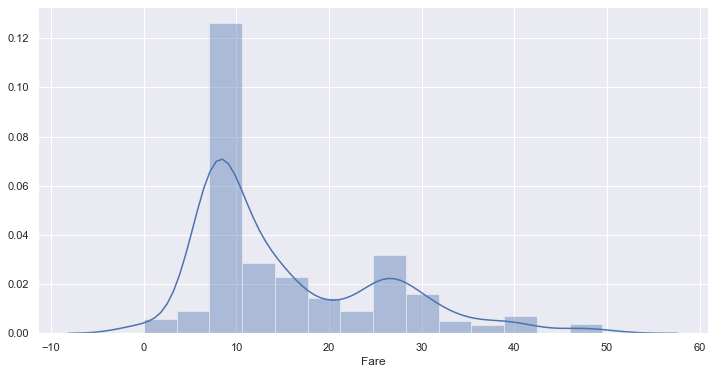

In [63]:
low_train_data['Fare'].describe()
plt.figure(figsize=(12, 6))
# sns.distplot(low_train_data.Fare)
checkOutlier = low_train_data[low_train_data.Fare < 50]
checkOutlier['Fare'].describe() # -> std ≒ 10

sns.distplot(checkOutlier['Fare'])

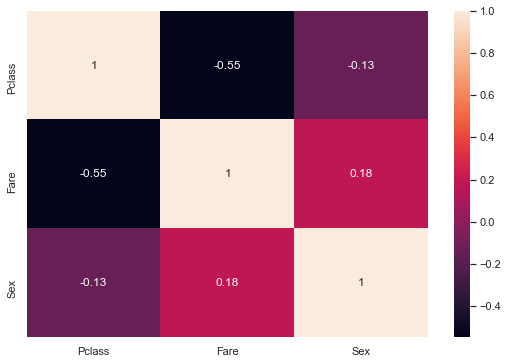

In [64]:
# create train data
train_data = pd.DataFrame({'Pclass': low_train_data['Pclass'], 'Fare': low_train_data['Fare'], 'Sex':low_train_data['Sex']})
# train_data = train_data.T
plt.figure(figsize=(9, 6))

train_data['Sex'].replace({'male': 0, 'female': 1}, inplace=True)

sns.heatmap(train_data.corr(), annot=True)

In [65]:
# To start processing
# x_train
x_train = train_data[0: 600].values
# t_train
t_train = low_train_data[0: 600].get('Survived').values
# x_test
x_test = train_data[600: train_data.shape[0]].values
# t_test
t_test = low_train_data[600: train_data.shape[0]].get('Survived').values
# To create network
network = MultiLayerNetExtend(input_size=train_data.columns.shape[0], hidden_size_list=[100, 100, 100, 100, 100], output_size=2,
                                 weight_init_std=0.1, use_batchnorm=True)
# To start predict
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 150
learning_rate = 0.001

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, t_batch)

    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % 100 == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('Tern: ' + str(i) + 'train accuracy: ' + str(train_acc) + ' test accuracy: ' + str(test_acc))

Tern: 0train accuracy: 0.395 test accuracy: 0.37800687285223367
Tern: 100train accuracy: 0.6783333333333333 test accuracy: 0.7560137457044673
Tern: 200train accuracy: 0.7183333333333334 test accuracy: 0.7491408934707904
Tern: 300train accuracy: 0.7916666666666666 test accuracy: 0.7903780068728522
Tern: 400train accuracy: 0.7583333333333333 test accuracy: 0.7731958762886598
Tern: 500train accuracy: 0.78 test accuracy: 0.7938144329896907
Tern: 600train accuracy: 0.78 test accuracy: 0.7903780068728522
Tern: 700train accuracy: 0.78 test accuracy: 0.7800687285223368
Tern: 800train accuracy: 0.7616666666666667 test accuracy: 0.7835051546391752
Tern: 900train accuracy: 0.7883333333333333 test accuracy: 0.7869415807560137
Tern: 1000train accuracy: 0.7216666666666667 test accuracy: 0.738831615120275
Tern: 1100train accuracy: 0.7866666666666666 test accuracy: 0.8006872852233677
Tern: 1200train accuracy: 0.7966666666666666 test accuracy: 0.7938144329896907
Tern: 1300train accuracy: 0.775 test acc

In [66]:
test_data = pd.DataFrame({'Pclass': low_test_data['Pclass'], 'Fare': low_test_data['Fare'], 'Sex':low_test_data['Sex']})
test_data['Sex'].replace({'male': 0, 'female': 1}, inplace=True)
test_data = test_data.values

low_result = network.predict(test_data)
survived = []

pid = low_test_data['PassengerId']

for i in low_result:
    survived.append(0) if i[0] > i[1] else survived.append(1)

survivedDf = pd.DataFrame(survived, index=pid, columns=['Survived'])

survivedDf.to_csv('../Titanic/result.csv')

print('fin')

fin


/Users/subarushiozaki/PycharmProjects/ForKaggle/Titanic/common/layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
